(ray/01-ray-ai)=
# Ray AI Runtime

![Status](https://img.shields.io/static/v1.svg?label=Status&message=Finished&color=brightgreen)
[![Source](https://img.shields.io/static/v1.svg?label=GitHub&message=Source&color=181717&logo=GitHub)](https://github.com/particle1331/ok-transformer/blob/master/docs/nb/ray/01-ray-ai.ipynb)
[![Stars](https://img.shields.io/github/stars/particle1331/ok-transformer?style=social)](https://github.com/particle1331/ok-transformer)

---

**Readings:**  {cite}`timviera`

## Introduction

In this module, you will learn how to use Ray AIR to build an end-to-end machine learning application. It covers the entire process from data loading to training and hyperparameter tuning to prediction and serving. Along the way, each section will introduce you to key components of Ray AIR and provide hands-on coding exercises to demonstrate usage.

Goals 

* Understand the high-level ML libraries that make up Ray AIR.
    * Data
    * Train
    * Tune
    * Serve
    * RLlib (not covered in-depth in this module)
* Use Ray AIR as a unified toolkit to write an end-to-end ML applications.
* Extend mini-examples presented here to scale individual workloads in Python with Ray AIR.
* Identify the problems and challenges that Ray AIR attempts to solve.

### What will you do?

Through hands-on exercises, you will practice the key concepts from each stage of an example ML workflow.

|ML workflow stage|Ray AI key concept|
|:--|:--|
|Data loading and preprocessing|`Preprocessor` to load and transform data|
|Model training|`Trainer` for supported ML frameworks (Keras, Pytorch and more)|
|Hyperparameter tuning|`Tuner` for hyperparameter search|
|Batch prediction|`BatchPredictor` to load model from best checkpoint for batch inference|
|Model serving|`PredictorDeployment` for online inference|

Ray for ML infrastructure is a set of libraries that equips ML engineers, data scientists, and researchers with a scalable and unified toolkit for ML applications.
Built on top of Ray Core, these inherit all the performance and scalability benefits offered by Core while providing a convenient abstraction layer for machine learning. Ray's Python-first native libraries allow ML practitioners to distribute individual workloads, end-to-end applications, and build custom use cases in a unified framework.

## End-to-end workflow

To illustrate Ray AIR's capabilities, you will implement an end-to-end machine learning application that predicts big tips using New York City taxi data. Each section will introduce the relevant Ray AIR library or component and demonstrating its functionality through code examples.

|Ray AIR Component|NYC Taxi Use Case|
|:--|:--|
|Ray Data|Use `Preprocessor` to load and transform input data.|
|Ray Train|Use `Trainer` to scale XGBoost model training.|
|Ray Tune|Use `Tuner` for hyperparameter search.|
|Ray AIR Predictor|Use `BatchPredictor` to load model from best checkpoint for batch inference; part of Ray Train.|
|Ray Serve|Use `PredictorDeployment` for online inference.|

For this classification task, you will apply a simple [XGBoost](https://xgboost.readthedocs.io/en/stable/) (a gradient boosted trees framework) model to the June 2021 [New York City Taxi & Limousine Commission's Trip Record Data](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page). This dataset contains over 2 million samples of yellow cab rides, and the goal is to predict whether a trip will result in a tip greater than 20% or not.

**Dataset features**
* **`passenger_count`**
    * Float (whole number) representing number of passengers.
* **`trip_distance`** 
    * Float representing trip distance in miles.
* **`fare_amount`**
    * Float representing total price including tax, tip, fees, etc.
* **`trip_duration`**
    * Integer representing seconds elapsed.
* **`hour`**
    * Hour that the trip started.
    * Integer in the range `[0, 23]`
* **`day_of_week`**
    * Integer in the range `[1, 7]`.
* **`is_big_tip`**
    * Whether the tip amount was greater than 20%.
    * Boolean `[True, False]`.

## Introduction to Ray Datasets

Backed by PyArrow, [Ray Datasets](https://docs.ray.io/en/latest/data/user-guide.html) parallelize the loading and transforming of data and provide a standard way to pass references to data across Ray libraries and applications. Datasets are not intended to replace more general data processing systems. Instead, it serves as a last-mile bridge from ETL pipeline outputs to distributed applications and libraries in Ray.

#### Key features

- **Flexibility**

    Datasets are compatible with a variety of file formats, data sources, and distributed frameworks. They work seamlessly with library integrations like Dask on Ray and can be passed between Ray tasks and actors without copying data.

- **Performance for ML Workloads**

    Datasets offer important features like accelerator support, pipelining, and global random shuffles that accelerate ML training and inference workloads. They also support basic distributed data transformations such as map, filter, sort, groupby, and repartition.

- **Persistent Preprocessor**

    The `Preprocessor` primitive captures and stores the transformations applied to convert inputs into features. It is applied during training, tuning, batch prediction, and serving to keep the preprocessing consistent across the pipeline.
    
- **Built on Ray Core**

    Datasets inherits scalability to hundreds of nodes, efficient memory usage, object spilling, and failure handling from Ray Core. Because Datasets are just lists of object references, they can be passed between tasks and actors without needing to make a copy of the data, which is crucial for making data-intensive applications and libraries scalable.

With this generic structure in mind, you will see how it is applied with the tip prediction task.

for the sake of presentation, we will disable logging. but note that this masks important information about the behavior of the program.

In [1]:
import ray

if ray.is_initialized:
    ray.shutdown()

ray.init(configure_logging=False)

Python version:,3.9.15
Ray version:,2.8.1
Dashboard:,http://127.0.0.1:8266


In [2]:
# Read Parquet file to Ray Dataset. (e.g. s3://)
dataset = ray.data.read_parquet(
    "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet"
)

# Split data into training and validation subsets.
train_ds, valid_ds = dataset.train_test_split(test_size=0.3, shuffle=True)

# Split datasets into blocks for parallel preprocessing.
# `num_blocks` should be lower than number of cores in the cluster.
train_ds = train_ds.repartition(num_blocks=5)
valid_ds = valid_ds.repartition(num_blocks=5)

(pid=47305) Parquet Files Sample 0:   0%|          | 0/1 [00:00<?, ?it/s]

- RandomShuffle 1:   0%|          | 0/200 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/200 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/200 [00:00<?, ?it/s]

Running 0:   0%|          | 0/200 [00:00<?, ?it/s]

In [4]:
print(f"Schema of training dataset: \n {train_ds.schema()}")

Schema of training dataset: 
 Column                 Type
------                 ----
VendorID               int64
tpep_pickup_datetime   timestamp[us]
tpep_dropoff_datetime  timestamp[us]
passenger_count        double
trip_distance          double
RatecodeID             double
store_and_fwd_flag     string
PULocationID           int64
DOLocationID           int64
payment_type           int64
fare_amount            double
extra                  double
mta_tax                double
tip_amount             double
tolls_amount           double
improvement_surcharge  double
total_amount           double
congestion_surcharge   double
airport_fee            double


Need to include only relevant columns as well as add the label: 
Note: can also use map on a function that transforms per row but this can be slow.

In [9]:
import pandas as pd

cols_to_keep = [
    "passenger_count",
    "trip_distance",
    "fare_amount",
    "trip_duration",
    "hour",
    "day_of_week",
    "is_big_tip"
]

def preprocess(batch):
    dropoff = batch["tpep_dropoff_datetime"]
    pickup = batch["tpep_pickup_datetime"]
    batch["trip_duration"] = (dropoff - pickup).dt.seconds
    batch["hour"] = pickup.dt.hour
    batch["day_of_week"] = pickup.dt.dayofweek
    batch["is_big_tip"] = (batch["tip_amount"] >= 0.20 * batch["fare_amount"]).astype(int)
    return batch[cols_to_keep].dropna()


train_ds.map_batches(preprocess, batch_format="pandas").limit(5).to_pandas()

- Repartition 1:   0%|          | 0/5 [00:00<?, ?it/s]

Split Repartition 2:   0%|          | 0/5 [00:00<?, ?it/s]

Running 0:   0%|          | 0/5 [00:00<?, ?it/s]

,passenger_count,trip_distance,fare_amount,trip_duration,hour,day_of_week,is_big_tip
0,1.0,2.63,15.6,822,14,3,1
1,1.0,1.70,9.3,350,1,0,1
2,1.0,1.47,14.9,950,15,2,0
3,3.0,1.50,10.7,714,16,1,0
4,0.0,6.10,31.7,1560,11,6,0


In [10]:
print(f"Number of samples in training dataset: \n {train_ds.count()}")

Number of samples in training dataset: 
 2146736


In [11]:
print(f"Number of samples in validation dataset: \n {valid_ds.count()}")

Number of samples in validation dataset: 
 920030


- Repartition 1:   0%|          | 0/5 [00:00<?, ?it/s]

Split Repartition 2:   0%|          | 0/5 [00:00<?, ?it/s]

Running 0:   0%|          | 0/5 [00:00<?, ?it/s]

<Axes: xlabel='passenger_count', ylabel='tip_amount'>

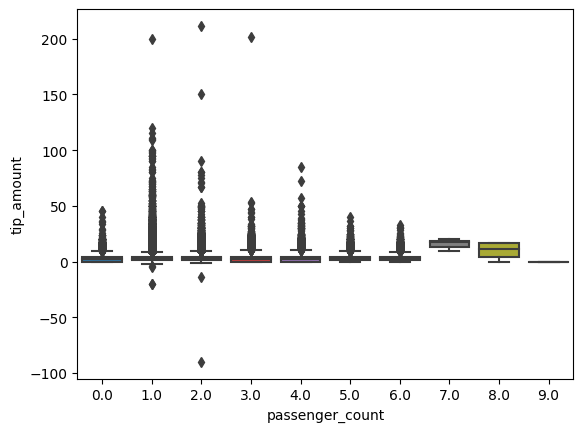

In [16]:
import seaborn as sns
data = train_ds.random_sample(fraction=0.3).to_pandas()
sns.boxplot(data=data, x="passenger_count", y="tip_amount")

```{figure} img/01-object-store-memory.png
---
name: 01-object-store-memory
width: 100%
---
539MB is stored in the object store.
```

Ray scikit preprocessors. See [docs](https://docs.ray.io/en/latest/data/preprocessors.html):

| Method | Description |
| --- | --- |
| `fit()` | Compute state information about a `Dataset` (for example, the mean or standard deviation of a column) and save it to the Preprocessor. This information is used to perform transform(), and the method is typically called on a training dataset. |
| `transform()` | Apply a transformation to a `Dataset`. If the Preprocessor is stateful, then fit() must be called first. This method is typically called on training, validation, and test datasets. |
| `transform_batch()` | Apply a transformation to a single batch of data. This method is typically called on online or offline inference data. |
| `fit_transform()` | Syntactic sugar for calling both `fit()` and `transform()` on a `Dataset`. |



In [19]:
data[list(set(data.columns) & set(cols_to_keep))].describe()

,trip_distance,fare_amount,passenger_count
count,645028.000000,645028.000000,629920.000000
mean,3.703190,18.364893,1.362354
std,114.277311,17.775240,0.895415
min,0.000000,-600.000000,0.000000
25%,1.060000,8.600000,1.000000
50%,1.800000,12.800000,1.000000
75%,3.330000,20.500000,1.000000
max,85543.660000,1160.100000,9.000000


In [21]:
from ray.data.preprocessors import StandardScaler

scaler = StandardScaler(columns=["trip_distance", "trip_duration", "fare_amount"])
scaler.fit(train_ds.map_batches(preprocess, batch_format="pandas"))
scaler.stats_

- Repartition 1:   0%|          | 0/5 [00:00<?, ?it/s]

Split Repartition 2:   0%|          | 0/5 [00:00<?, ?it/s]

- Aggregate 3:   0%|          | 0/5 [00:00<?, ?it/s]

Shuffle Map 4:   0%|          | 0/5 [00:00<?, ?it/s]

Shuffle Reduce 5:   0%|          | 0/5 [00:00<?, ?it/s]

Running 0:   0%|          | 0/5 [00:00<?, ?it/s]

{'mean(trip_distance)': 3.4067745788315604,
 'mean(trip_duration)': 938.1569791208062,
 'mean(fare_amount)': 18.313019677184094,
 'std(trip_distance)': 18.709362337663045,
 'std(trip_duration)': 2531.2930804088355,
 'std(fare_amount)': 17.872701135191136}

Filtering outliers on validation dataset:

In [25]:
def zscore(row, key: str):
    return abs(row[key] - scaler.stats_[f"mean({key})"]) / scaler.stats_[f"std({key})"]

def filter_outliers(row):
    trip_distance = zscore(row, "trip_distance") < 5
    trip_duration = zscore(row, "trip_duration") < 5
    fare_amount = zscore(row, "fare_amount") < 5
    return trip_distance and trip_duration and fare_amount


# order of maps important
df_train = train_ds.random_sample(fraction=0.2).map_batches(preprocess, batch_format="pandas").filter(filter_outliers).to_pandas()
df_valid = valid_ds.random_sample(fraction=0.2).map_batches(preprocess, batch_format="pandas").filter(filter_outliers).to_pandas()

- Repartition 1:   0%|          | 0/5 [00:00<?, ?it/s]

Split Repartition 2:   0%|          | 0/5 [00:00<?, ?it/s]

Running 0:   0%|          | 0/5 [00:00<?, ?it/s]

- Repartition 1:   0%|          | 0/5 [00:00<?, ?it/s]

Split Repartition 2:   0%|          | 0/5 [00:00<?, ?it/s]

Running 0:   0%|          | 0/5 [00:00<?, ?it/s]

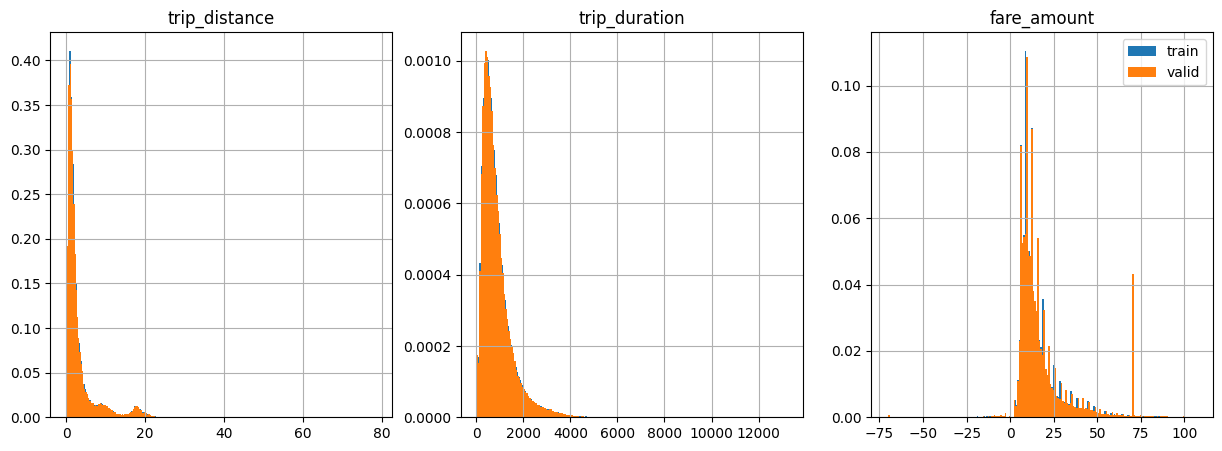

In [30]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

df_train.trip_distance.hist(bins=200, density=True, ax=ax[0], label="train")
df_valid.trip_distance.hist(bins=200, density=True, ax=ax[0], label="valid")
df_train.trip_duration.hist(bins=200, density=True, ax=ax[1], label="train")
df_valid.trip_duration.hist(bins=200, density=True, ax=ax[1], label="valid")
df_train.fare_amount.hist(bins=200, density=True, ax=ax[2], label="train")
df_valid.fare_amount.hist(bins=200, density=True, ax=ax[2], label="valid")

ax[0].set_title("trip_distance")
ax[1].set_title("trip_duration")
ax[2].set_title("fare_amount")
ax[2].legend();

In [35]:
transformed_train = train_ds.map_batches(preprocess, batch_format="pandas").filter(filter_outliers).map_batches(scaler.transform_batch)
transformed_valid = valid_ds.map_batches(preprocess, batch_format="pandas").filter(filter_outliers).map_batches(scaler.transform_batch)

In [42]:
from ray.air.config import ScalingConfig
from ray.train.xgboost import XGBoostTrainer

trainer = XGBoostTrainer(
    label_column="is_big_tip",
    num_boost_round=50,
    scaling_config=ScalingConfig(
        num_workers=5,
        use_gpu=False,
    ),
    params={
        "objective": "binary:logistic",
        "eval_metric": ["logloss", "error"],
        "tree_method": "approx",
    },
    datasets={"train": transformed_train, "valid": transformed_valid},
)

In [43]:
result = trainer.fit()

(XGBoostTrainer pid=47503) [RayXGBoost] Created 5 new actors (5 total actors). Waiting until actors are ready for training.
(XGBoostTrainer pid=47503) Executing DAG InputDataBuffer[Input] -> AllToAllOperator[Repartition] -> TaskPoolMapOperator[MapBatches(preprocess)->Filter(filter_outliers)->MapBatches(StandardScaler.transform_batch)]
(XGBoostTrainer pid=47503) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
(XGBoostTrainer pid=47503) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


(pid=47503) - Repartition 1:   0%|          | 0/5 [00:00<?, ?it/s]

(pid=47503) Split Repartition 2:   0%|          | 0/5 [00:00<?, ?it/s]

(pid=47503) Running 0:   0%|          | 0/5 [00:00<?, ?it/s]

(XGBoostTrainer pid=47503) Executing DAG InputDataBuffer[Input] -> AllToAllOperator[Repartition] -> TaskPoolMapOperator[MapBatches(preprocess)->Filter(filter_outliers)->MapBatches(StandardScaler.transform_batch)]
(XGBoostTrainer pid=47503) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
(XGBoostTrainer pid=47503) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


(pid=47503) - Repartition 1:   0%|          | 0/5 [00:00<?, ?it/s]

(pid=47503) Split Repartition 2:   0%|          | 0/5 [00:00<?, ?it/s]

(pid=47503) Running 0:   0%|          | 0/5 [00:00<?, ?it/s]

(XGBoostTrainer pid=47503) [RayXGBoost] Starting XGBoost training.
(_RemoteRayXGBoostActor pid=47510) [01:32:24] task [xgboost.ray]:5852381824 got new rank 4
(XGBoostTrainer pid=47503) [RayXGBoost] Finished XGBoost training on training data with total N=2,090,270 in 421.29 seconds (23.41 pure XGBoost training time).
(XGBoostTrainer pid=47503) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/particle1331/ray_results/XGBoostTrainer_2023-12-12_01-25-41/XGBoostTrainer_4f2be_00000_0_2023-12-12_01-25-41/checkpoint_000000)
(_RemoteRayXGBoostActor pid=47508) [01:32:24] task [xgboost.ray]:5163080720 got new rank 2 [repeated 4x across cluster]


In [ ]:
from pprint import pprint
pprint(result.metrics)

{'checkpoint_dir_name': 'checkpoint_000000',
 'config': {},
 'date': '2023-12-11_22-19-23',
 'done': True,
 'experiment_tag': '0',
 'hostname': 'MacBook-Air.local',
 'iterations_since_restore': 51,
 'node_ip': '127.0.0.1',
 'pid': 44964,
 'should_checkpoint': True,
 'time_since_restore': 67.33735942840576,
 'time_this_iter_s': 0.08819103240966797,
 'time_total_s': 67.33735942840576,
 'timestamp': 1702304363,
 'train-error': 0.37107067516709225,
 'train-logloss': 0.6465804877782414,
 'training_iteration': 51,
 'trial_id': '1c7a2_00000',
 'valid-error': 0.36603915089725336,
 'valid-logloss': 0.6453477893263155,
 'valid_filtered-error': 0.3660964314900572,
 'valid_filtered-logloss': 0.6452991140412185}


In [ ]:
print(f"Training accuracy: {1 - result.metrics['train-error']:.4f}")
print(f"Validation accuracy: {1 - result.metrics['valid-error']:.4f}")
print(f"Validation (filtered) accuracy: {1 - result.metrics['valid_filtered-error']:.4f}")

Training accuracy: 0.6289
Validation accuracy: 0.6340
Validation (filtered) accuracy: 0.6339


In [46]:
from xgboost import DMatrix

checkpoint = result.checkpoint
xgb_model = trainer.get_model(checkpoint)

def correct_preds(batch):
    X = DMatrix(batch.drop("is_big_tip", axis=1))
    y = batch["is_big_tip"]
    return {"data": ((xgb_model.predict(X) > 0.5) == y).astype(int)}


BATCH_SIZE = 32
print(transformed_valid.map_batches(correct_preds, batch_format="pandas", batch_size=BATCH_SIZE).mean("data"))

- Repartition 1:   0%|          | 0/5 [00:00<?, ?it/s]

Split Repartition 2:   0%|          | 0/5 [00:00<?, ?it/s]

- Aggregate 3:   0%|          | 0/5 [00:00<?, ?it/s]

Shuffle Map 4:   0%|          | 0/5 [00:00<?, ?it/s]

Shuffle Reduce 5:   0%|          | 0/5 [00:00<?, ?it/s]

Running 0:   0%|          | 0/5 [00:00<?, ?it/s]

KeyboardInterrupt: 

tune

In [44]:
from ray import tune
from ray.tune.tuner import Tuner, TuneConfig

# Define a search space of hyperparameters.
param_space = {
    "params": {
        "eta": tune.uniform(0.2, 0.4), # learning rate
        "max_depth": tune.randint(1, 6), # default=6; higher value means more complex tree
        "min_child_weight": tune.uniform(0.8, 1.0), # min sum of weights of all data in a child
    }
}

tuner = Tuner(
    trainer,
    param_space=param_space,
    tune_config=TuneConfig(num_samples=10, metric="train-logloss", mode="min"),
)

result_grid = tuner.fit()


(XGBoostTrainer pid=47687) [RayXGBoost] Created 5 new actors (5 total actors). Waiting until actors are ready for training.
(XGBoostTrainer pid=47687) Executing DAG InputDataBuffer[Input] -> AllToAllOperator[Repartition] -> TaskPoolMapOperator[MapBatches(preprocess)->Filter(filter_outliers)->MapBatches(StandardScaler.transform_batch)]
(XGBoostTrainer pid=47687) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
(XGBoostTrainer pid=47687) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


(pid=47687) - Repartition 1:   0%|          | 0/5 [00:00<?, ?it/s]

(pid=47687) Split Repartition 2:   0%|          | 0/5 [00:00<?, ?it/s]

(pid=47687) Running 0:   0%|          | 0/5 [00:00<?, ?it/s]

(XGBoostTrainer pid=47687) Executing DAG InputDataBuffer[Input] -> AllToAllOperator[Repartition] -> TaskPoolMapOperator[MapBatches(preprocess)->Filter(filter_outliers)->MapBatches(StandardScaler.transform_batch)]
(XGBoostTrainer pid=47687) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
(XGBoostTrainer pid=47687) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


(pid=47687) - Repartition 1:   0%|          | 0/5 [00:00<?, ?it/s]

(pid=47687) Split Repartition 2:   0%|          | 0/5 [00:00<?, ?it/s]

(pid=47687) Running 0:   0%|          | 0/5 [00:00<?, ?it/s]

(XGBoostTrainer pid=47687) [RayXGBoost] Starting XGBoost training.
(_RemoteRayXGBoostActor pid=47691) [02:31:57] task [xgboost.ray]:5266592720 got new rank 1
(XGBoostTrainer pid=47687) [RayXGBoost] Finished XGBoost training on training data with total N=2,090,270 in 3356.97 seconds (12.17 pure XGBoost training time).
(XGBoostTrainer pid=47687) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/particle1331/ray_results/XGBoostTrainer_2023-12-12_01-36-08/XGBoostTrainer_c4ec6_00000_0_eta=0.2632,max_depth=4,min_child_weight=0.9494_2023-12-12_01-36-08/checkpoint_000000)
(_RemoteRayXGBoostActor pid=47693) [02:31:57] task [xgboost.ray]:5388911328 got new rank 3 [repeated 4x across cluster]
(XGBoostTrainer pid=47878) [RayXGBoost] Created 5 new actors (5 total actors). Waiting until actors are ready for training.
(XGBoostTrainer pid=47878) Executing DAG InputDataBuffer[Input] -> AllToAllOperator[Repartition] -> TaskPoolMapOperator[MapBatches(preprocess)->Filter(filter_

(pid=47878) - Repartition 1:   0%|          | 0/5 [00:00<?, ?it/s]

(pid=47878) Split Repartition 2:   0%|          | 0/5 [00:00<?, ?it/s]

(pid=47878) Running 0:   0%|          | 0/5 [00:00<?, ?it/s]

(XGBoostTrainer pid=47878) Executing DAG InputDataBuffer[Input] -> AllToAllOperator[Repartition] -> TaskPoolMapOperator[MapBatches(preprocess)->Filter(filter_outliers)->MapBatches(StandardScaler.transform_batch)]
(XGBoostTrainer pid=47878) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
(XGBoostTrainer pid=47878) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


(pid=47878) - Repartition 1:   0%|          | 0/5 [00:00<?, ?it/s]

(pid=47878) Split Repartition 2:   0%|          | 0/5 [00:00<?, ?it/s]

(pid=47878) Running 0:   0%|          | 0/5 [00:00<?, ?it/s]

(XGBoostTrainer pid=47878) [RayXGBoost] Starting XGBoost training.
(_RemoteRayXGBoostActor pid=47885) [02:35:45] task [xgboost.ray]:5816632128 got new rank 0
(XGBoostTrainer pid=47878) [RayXGBoost] Finished XGBoost training on training data with total N=2,090,270 in 225.98 seconds (13.33 pure XGBoost training time).
(XGBoostTrainer pid=47878) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/particle1331/ray_results/XGBoostTrainer_2023-12-12_01-36-08/XGBoostTrainer_c4ec6_00001_1_eta=0.3703,max_depth=5,min_child_weight=0.8162_2023-12-12_01-36-08/checkpoint_000000)
(_RemoteRayXGBoostActor pid=47887) [02:35:45] task [xgboost.ray]:5281071744 got new rank 2 [repeated 4x across cluster]
(XGBoostTrainer pid=47994) [RayXGBoost] Created 5 new actors (5 total actors). Waiting until actors are ready for training.
(XGBoostTrainer pid=47994) Executing DAG InputDataBuffer[Input] -> AllToAllOperator[Repartition] -> TaskPoolMapOperator[MapBatches(preprocess)->Filter(filter_o

(pid=47994) - Repartition 1:   0%|          | 0/5 [00:00<?, ?it/s]

(pid=47994) Split Repartition 2:   0%|          | 0/5 [00:00<?, ?it/s]

(pid=47994) Running 0:   0%|          | 0/5 [00:00<?, ?it/s]

(XGBoostTrainer pid=47994) Executing DAG InputDataBuffer[Input] -> AllToAllOperator[Repartition] -> TaskPoolMapOperator[MapBatches(preprocess)->Filter(filter_outliers)->MapBatches(StandardScaler.transform_batch)]
(XGBoostTrainer pid=47994) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
(XGBoostTrainer pid=47994) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


(pid=47994) - Repartition 1:   0%|          | 0/5 [00:00<?, ?it/s]

(pid=47994) Split Repartition 2:   0%|          | 0/5 [00:00<?, ?it/s]

(pid=47994) Running 0:   0%|          | 0/5 [00:00<?, ?it/s]

(XGBoostTrainer pid=47994) [RayXGBoost] Starting XGBoost training.
(_RemoteRayXGBoostActor pid=47999) [02:39:42] task [xgboost.ray]:4831331040 got new rank 2
(XGBoostTrainer pid=47994) [RayXGBoost] Finished XGBoost training on training data with total N=2,090,270 in 232.29 seconds (12.26 pure XGBoost training time).
(_RemoteRayXGBoostActor pid=48001) [02:39:42] task [xgboost.ray]:5072769760 got new rank 4 [repeated 4x across cluster]
(XGBoostTrainer pid=47994) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/particle1331/ray_results/XGBoostTrainer_2023-12-12_01-36-08/XGBoostTrainer_c4ec6_00002_2_eta=0.2392,max_depth=4,min_child_weight=0.9353_2023-12-12_01-36-08/checkpoint_000000)
(XGBoostTrainer pid=48050) [RayXGBoost] Created 5 new actors (5 total actors). Waiting until actors are ready for training.
(XGBoostTrainer pid=48050) Executing DAG InputDataBuffer[Input] -> AllToAllOperator[Repartition] -> TaskPoolMapOperator[MapBatches(preprocess)->Filter(filter_o

(pid=48050) - Repartition 1:   0%|          | 0/5 [00:00<?, ?it/s]

(pid=48050) Split Repartition 2:   0%|          | 0/5 [00:00<?, ?it/s]

(pid=48050) Running 0:   0%|          | 0/5 [00:00<?, ?it/s]

(XGBoostTrainer pid=48050) Executing DAG InputDataBuffer[Input] -> AllToAllOperator[Repartition] -> TaskPoolMapOperator[MapBatches(preprocess)->Filter(filter_outliers)->MapBatches(StandardScaler.transform_batch)]
(XGBoostTrainer pid=48050) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
(XGBoostTrainer pid=48050) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


(pid=48050) - Repartition 1:   0%|          | 0/5 [00:00<?, ?it/s]

(pid=48050) Split Repartition 2:   0%|          | 0/5 [00:00<?, ?it/s]

(pid=48050) Running 0:   0%|          | 0/5 [00:00<?, ?it/s]

(XGBoostTrainer pid=48050) [RayXGBoost] Starting XGBoost training.
(_RemoteRayXGBoostActor pid=48053) [02:43:33] task [xgboost.ray]:4954010576 got new rank 0
(XGBoostTrainer pid=48050) [RayXGBoost] Finished XGBoost training on training data with total N=2,090,270 in 230.15 seconds (13.78 pure XGBoost training time).
(XGBoostTrainer pid=48050) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/particle1331/ray_results/XGBoostTrainer_2023-12-12_01-36-08/XGBoostTrainer_c4ec6_00003_3_eta=0.2306,max_depth=1,min_child_weight=0.9602_2023-12-12_01-36-08/checkpoint_000000)
(_RemoteRayXGBoostActor pid=48055) [02:43:33] task [xgboost.ray]:4962665424 got new rank 2 [repeated 4x across cluster]
(XGBoostTrainer pid=48129) [RayXGBoost] Created 5 new actors (5 total actors). Waiting until actors are ready for training.
(XGBoostTrainer pid=48129) Executing DAG InputDataBuffer[Input] -> AllToAllOperator[Repartition] -> TaskPoolMapOperator[MapBatches(preprocess)->Filter(filter_o

(pid=48129) - Repartition 1:   0%|          | 0/5 [00:00<?, ?it/s]

(pid=48129) Split Repartition 2:   0%|          | 0/5 [00:00<?, ?it/s]

(pid=48129) Running 0:   0%|          | 0/5 [00:00<?, ?it/s]

(XGBoostTrainer pid=48129) Executing DAG InputDataBuffer[Input] -> AllToAllOperator[Repartition] -> TaskPoolMapOperator[MapBatches(preprocess)->Filter(filter_outliers)->MapBatches(StandardScaler.transform_batch)]
(XGBoostTrainer pid=48129) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
(XGBoostTrainer pid=48129) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


(pid=48129) - Repartition 1:   0%|          | 0/5 [00:00<?, ?it/s]

(pid=48129) Split Repartition 2:   0%|          | 0/5 [00:00<?, ?it/s]

(pid=48129) Running 0:   0%|          | 0/5 [00:00<?, ?it/s]

(XGBoostTrainer pid=48129) [RayXGBoost] Starting XGBoost training.
(_RemoteRayXGBoostActor pid=48132) [02:48:44] task [xgboost.ray]:5038396032 got new rank 0
(XGBoostTrainer pid=48129) [RayXGBoost] Finished XGBoost training on training data with total N=2,090,270 in 319.31 seconds (25.77 pure XGBoost training time).
(XGBoostTrainer pid=48129) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/particle1331/ray_results/XGBoostTrainer_2023-12-12_01-36-08/XGBoostTrainer_c4ec6_00004_4_eta=0.2045,max_depth=4,min_child_weight=0.9268_2023-12-12_01-36-08/checkpoint_000000)
(_RemoteRayXGBoostActor pid=48133) [02:48:44] task [xgboost.ray]:5000639440 got new rank 1 [repeated 4x across cluster]
(XGBoostTrainer pid=48302) [RayXGBoost] Created 5 new actors (5 total actors). Waiting until actors are ready for training.
(XGBoostTrainer pid=48302) Executing DAG InputDataBuffer[Input] -> AllToAllOperator[Repartition] -> TaskPoolMapOperator[MapBatches(preprocess)->Filter(filter_o

(pid=48302) - Repartition 1:   0%|          | 0/5 [00:00<?, ?it/s]

(pid=48302) Split Repartition 2:   0%|          | 0/5 [00:00<?, ?it/s]

(pid=48302) Running 0:   0%|          | 0/5 [00:00<?, ?it/s]

(XGBoostTrainer pid=48302) Executing DAG InputDataBuffer[Input] -> AllToAllOperator[Repartition] -> TaskPoolMapOperator[MapBatches(preprocess)->Filter(filter_outliers)->MapBatches(StandardScaler.transform_batch)]
(XGBoostTrainer pid=48302) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
(XGBoostTrainer pid=48302) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


(pid=48302) - Repartition 1:   0%|          | 0/5 [00:00<?, ?it/s]

(pid=48302) Split Repartition 2:   0%|          | 0/5 [00:00<?, ?it/s]

(pid=48302) Running 0:   0%|          | 0/5 [00:00<?, ?it/s]

(XGBoostTrainer pid=48302) [RayXGBoost] Starting XGBoost training.
(_RemoteRayXGBoostActor pid=48305) [02:55:35] task [xgboost.ray]:5135946800 got new rank 0
(XGBoostTrainer pid=48302) [RayXGBoost] Finished XGBoost training on training data with total N=2,090,270 in 404.10 seconds (23.21 pure XGBoost training time).
(XGBoostTrainer pid=48302) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/particle1331/ray_results/XGBoostTrainer_2023-12-12_01-36-08/XGBoostTrainer_c4ec6_00005_5_eta=0.3567,max_depth=4,min_child_weight=0.9291_2023-12-12_01-36-08/checkpoint_000000)
(_RemoteRayXGBoostActor pid=48308) [02:55:35] task [xgboost.ray]:5826540496 got new rank 3 [repeated 4x across cluster]
(XGBoostTrainer pid=48441) [RayXGBoost] Created 5 new actors (5 total actors). Waiting until actors are ready for training.
(XGBoostTrainer pid=48441) Executing DAG InputDataBuffer[Input] -> AllToAllOperator[Repartition] -> TaskPoolMapOperator[MapBatches(preprocess)->Filter(filter_o

(pid=48441) - Repartition 1:   0%|          | 0/5 [00:00<?, ?it/s]

(pid=48441) Split Repartition 2:   0%|          | 0/5 [00:00<?, ?it/s]

(pid=48441) Running 0:   0%|          | 0/5 [00:00<?, ?it/s]

(XGBoostTrainer pid=48441) Executing DAG InputDataBuffer[Input] -> AllToAllOperator[Repartition] -> TaskPoolMapOperator[MapBatches(preprocess)->Filter(filter_outliers)->MapBatches(StandardScaler.transform_batch)]
(XGBoostTrainer pid=48441) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
(XGBoostTrainer pid=48441) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


(pid=48441) - Repartition 1:   0%|          | 0/5 [00:00<?, ?it/s]

(pid=48441) Split Repartition 2:   0%|          | 0/5 [00:00<?, ?it/s]

(pid=48441) Running 0:   0%|          | 0/5 [00:00<?, ?it/s]

(XGBoostTrainer pid=48441) [RayXGBoost] Starting XGBoost training.
(_RemoteRayXGBoostActor pid=48444) [03:02:15] task [xgboost.ray]:5173171152 got new rank 0
(XGBoostTrainer pid=48441) [RayXGBoost] Finished XGBoost training on training data with total N=2,090,270 in 394.12 seconds (21.50 pure XGBoost training time).
(XGBoostTrainer pid=48441) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/particle1331/ray_results/XGBoostTrainer_2023-12-12_01-36-08/XGBoostTrainer_c4ec6_00006_6_eta=0.2526,max_depth=3,min_child_weight=0.8288_2023-12-12_01-36-08/checkpoint_000000)
(_RemoteRayXGBoostActor pid=48447) [03:02:15] task [xgboost.ray]:5144761296 got new rank 3 [repeated 4x across cluster]
(XGBoostTrainer pid=48773) [RayXGBoost] Created 5 new actors (5 total actors). Waiting until actors are ready for training.
(XGBoostTrainer pid=48773) Executing DAG InputDataBuffer[Input] -> AllToAllOperator[Repartition] -> TaskPoolMapOperator[MapBatches(preprocess)->Filter(filter_o

(pid=48773) - Repartition 1:   0%|          | 0/5 [00:00<?, ?it/s]

(pid=48773) Split Repartition 2:   0%|          | 0/5 [00:00<?, ?it/s]

(pid=48773) Running 0:   0%|          | 0/5 [00:00<?, ?it/s]

(XGBoostTrainer pid=48773) Executing DAG InputDataBuffer[Input] -> AllToAllOperator[Repartition] -> TaskPoolMapOperator[MapBatches(preprocess)->Filter(filter_outliers)->MapBatches(StandardScaler.transform_batch)]
(XGBoostTrainer pid=48773) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
(XGBoostTrainer pid=48773) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


(pid=48773) - Repartition 1:   0%|          | 0/5 [00:00<?, ?it/s]

(pid=48773) Split Repartition 2:   0%|          | 0/5 [00:00<?, ?it/s]

(pid=48773) Running 0:   0%|          | 0/5 [00:00<?, ?it/s]

(XGBoostTrainer pid=48773) [RayXGBoost] Starting XGBoost training.
(_RemoteRayXGBoostActor pid=48776) [03:08:59] task [xgboost.ray]:5098984160 got new rank 0
(XGBoostTrainer pid=48773) [RayXGBoost] Finished XGBoost training on training data with total N=2,090,270 in 401.73 seconds (23.77 pure XGBoost training time).
(XGBoostTrainer pid=48773) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/particle1331/ray_results/XGBoostTrainer_2023-12-12_01-36-08/XGBoostTrainer_c4ec6_00007_7_eta=0.2760,max_depth=3,min_child_weight=0.8853_2023-12-12_01-36-08/checkpoint_000000)
(_RemoteRayXGBoostActor pid=48779) [03:08:59] task [xgboost.ray]:5833770032 got new rank 3 [repeated 4x across cluster]
(XGBoostTrainer pid=49061) [RayXGBoost] Created 5 new actors (5 total actors). Waiting until actors are ready for training.
(XGBoostTrainer pid=49061) Executing DAG InputDataBuffer[Input] -> AllToAllOperator[Repartition] -> TaskPoolMapOperator[MapBatches(preprocess)->Filter(filter_o

(pid=49061) - Repartition 1:   0%|          | 0/5 [00:00<?, ?it/s]

(pid=49061) Split Repartition 2:   0%|          | 0/5 [00:00<?, ?it/s]

(pid=49061) Running 0:   0%|          | 0/5 [00:00<?, ?it/s]

(XGBoostTrainer pid=49061) Executing DAG InputDataBuffer[Input] -> AllToAllOperator[Repartition] -> TaskPoolMapOperator[MapBatches(preprocess)->Filter(filter_outliers)->MapBatches(StandardScaler.transform_batch)]
(XGBoostTrainer pid=49061) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
(XGBoostTrainer pid=49061) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


(pid=49061) - Repartition 1:   0%|          | 0/5 [00:00<?, ?it/s]

(pid=49061) Split Repartition 2:   0%|          | 0/5 [00:00<?, ?it/s]

(pid=49061) Running 0:   0%|          | 0/5 [00:00<?, ?it/s]

(XGBoostTrainer pid=49061) [RayXGBoost] Starting XGBoost training.
(_RemoteRayXGBoostActor pid=49068) [03:15:35] task [xgboost.ray]:5165964736 got new rank 3
(XGBoostTrainer pid=49061) [RayXGBoost] Finished XGBoost training on training data with total N=2,090,270 in 391.39 seconds (22.58 pure XGBoost training time).
(_RemoteRayXGBoostActor pid=49065) [03:15:35] task [xgboost.ray]:5230113840 got new rank 0 [repeated 4x across cluster]
(XGBoostTrainer pid=49061) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/particle1331/ray_results/XGBoostTrainer_2023-12-12_01-36-08/XGBoostTrainer_c4ec6_00008_8_eta=0.2640,max_depth=3,min_child_weight=0.9515_2023-12-12_01-36-08/checkpoint_000000)


(pid=49143) - Repartition 1:   0%|          | 0/5 [00:00<?, ?it/s]

(pid=49143) Split Repartition 2:   0%|          | 0/5 [00:00<?, ?it/s]

(pid=49143) Running 0:   0%|          | 0/5 [00:00<?, ?it/s]

(XGBoostTrainer pid=49143) [RayXGBoost] Created 5 new actors (5 total actors). Waiting until actors are ready for training.
(XGBoostTrainer pid=49143) Executing DAG InputDataBuffer[Input] -> AllToAllOperator[Repartition] -> TaskPoolMapOperator[MapBatches(preprocess)->Filter(filter_outliers)->MapBatches(StandardScaler.transform_batch)]
(XGBoostTrainer pid=49143) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
(XGBoostTrainer pid=49143) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


(pid=49143) - Repartition 1:   0%|          | 0/5 [00:00<?, ?it/s]

(pid=49143) Split Repartition 2:   0%|          | 0/5 [00:00<?, ?it/s]

(pid=49143) Running 0:   0%|          | 0/5 [00:00<?, ?it/s]

(XGBoostTrainer pid=49143) Executing DAG InputDataBuffer[Input] -> AllToAllOperator[Repartition] -> TaskPoolMapOperator[MapBatches(preprocess)->Filter(filter_outliers)->MapBatches(StandardScaler.transform_batch)]
(XGBoostTrainer pid=49143) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
(XGBoostTrainer pid=49143) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`
(XGBoostTrainer pid=49143) [RayXGBoost] Starting XGBoost training.
(_RemoteRayXGBoostActor pid=49146) [03:22:15] task [xgboost.ray]:5097673536 got new rank 0
(XGBoostTrainer pid=49143) [RayXGBoost] Finished XGBoost training on training data with total N=2,090,270 in 398.07 seconds (24.42 pure XGBoost training time).
(_RemoteRayXGBoostActor pid=49147) [03:22:15] task [xgboost.ray]:498395243

In [ ]:
best_result = result_grid.get_best_result()

In [ ]:
print(f"Best result: \n {best_result} \n")
print(f"Training accuracy: {1 - best_result.metrics['train-error']:.4f}")
print(f"Validation accuracy: {1 - best_result.metrics['valid-error']:.4f}")

Best result: 
 Result(
  metrics={'train-logloss': 0.6487370377047185, 'train-error': 0.37302835837283355, 'valid-logloss': 0.6449890203995228, 'valid-error': 0.3648641892112214, 'valid_filtered-logloss': 0.6449513726686686, 'valid_filtered-error': 0.36490438572596023},
  path='/Users/particle1331/ray_results/XGBoostTrainer_2023-12-11_20-09-23/XGBoostTrainer_1f5d1_00002_2_eta=0.2718,max_depth=4,min_child_weight=0.8855_2023-12-11_20-09-23',
  filesystem='local',
  checkpoint=Checkpoint(filesystem=local, path=/Users/particle1331/ray_results/XGBoostTrainer_2023-12-11_20-09-23/XGBoostTrainer_1f5d1_00002_2_eta=0.2718,max_depth=4,min_child_weight=0.8855_2023-12-11_20-09-23/checkpoint_000000)
) 

Training accuracy: 0.6270
Validation accuracy: 0.6351


---

■